In [1]:
# Imports
import random
import pandas as pd
import numpy as np

# DAAT Imports
import daat
from daat import Instruction as daat_ins
from daat import daat_test

# TQDM
from tqdm.auto import tqdm, trange

# sklearn
import sklearn.svm as skl_svm
import sklearn.preprocessing as skl_prep

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Test 1: NASA KC1 Dataset

In [2]:
# globale Einstellungen
path_ds_nasa = "./data/kc1.csv"
ds_kc1 = pd.read_csv(path_ds_nasa)

In [3]:
# Analyser
an_nasa = daat.Analyser(ds_kc1)
an_nasa.drop_line([0,1])
an_nasa.transform_feature('defects')
an_nasa.show_dataset_info()

processing features:   0%|          | 0/22 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:          22
Anazhl Einträge:       2107
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : defects    | Anzahl 2          | ML Art: Klassifikation
größtes Feature   : e          | Anzahl 960        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
loc                  | float64    |       2107 |        138 |          0 ||       1.00 |       9.00 |     288.00 
v(g)                 | float64    |       2107 |         30 |          0 ||       1.00 |       1.00 |      45.00 
ev(g)                | float64    |       2107 |

complete:    2107 
train data:  1474   0.70 
test data:    633   0.30 
gen data:     632   0.30 


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

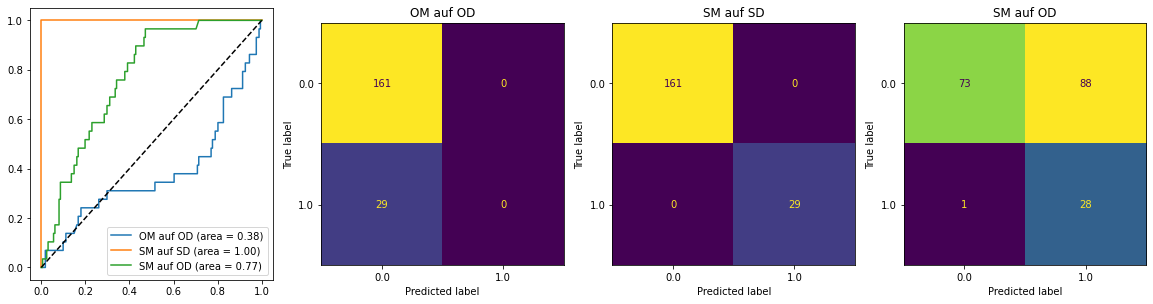

Auswertung Setup mit linearer SVC
Modell          | Accuracy   | Precision  | Recall     | F1        
OM auf OD       | 0.85       | 0.00       | 0.00       | 0.00      
SM auf SD       | 1.00       | 1.00       | 1.00       | 1.00      
SM auf OD       | 0.53       | 0.24       | 0.97       | 0.39      


0

In [4]:
ds_nasa_an = an_nasa.dataset
_, _ ,ds_nasa_gen = daat_test.split_data_from_all(ds_nasa_an, 'defects', 0.7, 0.3)

# Datensatz Augmentation Einstellung
aug_kc1 = daat.Generator(ds_nasa_gen, 'defects')

# Unabhängige Werte über Distribution
aug_kc1.add_instruction(daat_ins('total_Op', daat.Gen_Distribution(rng_min=0)))
aug_kc1.add_instruction(daat_ins('total_Opnd', daat.Gen_Distribution(rng_min=0)))

# uniq sollten jeweils kleiner sein als total -> total beachten
aug_kc1.add_instruction(daat_ins('uniq_Op', daat.Gen_NextMean(10), ['total_Op']))
aug_kc1.add_instruction(daat_ins('uniq_Opnd', daat.Gen_NextMean(10), ['total_Opnd']))

aug_kc1.add_instruction(daat_ins('lOCode', daat.Gen_NextMean(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('lOComment', daat.Gen_Cluster(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('lOBlank', daat.Gen_Cluster(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('locCodeAndComment', daat.Gen_None()))

# Alle berechneten Werte mit Spline
aug_kc1.add_instruction(daat_ins('n', daat.Gen_Spline(), ['total_Op', 'total_Opnd']))
aug_kc1.add_instruction(daat_ins('v', daat.Gen_Spline(), 'n'))
aug_kc1.add_instruction(daat_ins('l', daat.Gen_Spline(), ['uniq_Opnd', 'n'])) # berechnet mit v' (aus uniq_Opnd)
aug_kc1.add_instruction(daat_ins('d', daat.Gen_NextMean(5), 'l'))
aug_kc1.add_instruction(daat_ins('i', daat.Gen_NextMean(5), ['uniq_Opnd', 'd'])) # berechnet mit 1/l' (l' = 1/d)
aug_kc1.add_instruction(daat_ins('e', daat.Gen_Spline(), ['v', 'l'])) # berechnet mit l' und v'
aug_kc1.add_instruction(daat_ins('t', daat.Gen_Spline(), 'e'))
aug_kc1.add_instruction(daat_ins('b', daat.Gen_Spline(), ['n', 'v']))

aug_kc1.add_instruction(daat_ins('loc', daat.Gen_Recombine(5, rng_min=0), 'lOCode'))
aug_kc1.add_instruction(daat_ins('branchCount', daat.Gen_Recombine(15,rng_min=0), ['lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']))
aug_kc1.add_instruction(daat_ins('v(g)', daat.Gen_Spline(), 'branchCount'))
aug_kc1.add_instruction(daat_ins('ev(g)', daat.Gen_Spline(), 'branchCount'))
aug_kc1.add_instruction(daat_ins('iv(g)', daat.Gen_Spline(), 'branchCount'))

# aug_kc1.status()
aug_kc1.verify_setup()#balance=True)

In [5]:
aug_kc1.generate_syn_data(n_samples=len(ds_nasa_an), equal=True)
ds_aug_kc1 = aug_kc1.get_syn_data()

an_syn = daat.Analyser(ds_aug_kc1)
an_syn.show_dataset_info()

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing features:   0%|          | 0/22 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:          22
Anazhl Einträge:       2108
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : locCodeAndComment | Anzahl 1          | ML Art: Klassifikation
größtes Feature   : i          | Anzahl 295        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
loc                  | float64    |       2108 |         79 |          0 ||       1.00 |      23.00 |     179.00 
v(g)                 | float64    |       2108 |         19 |          0 ||       1.00 |       3.00 |      27.00 
ev(g)                | float64    |      

plotting data:   0%|          | 0/22 [00:00<?, ?it/s]

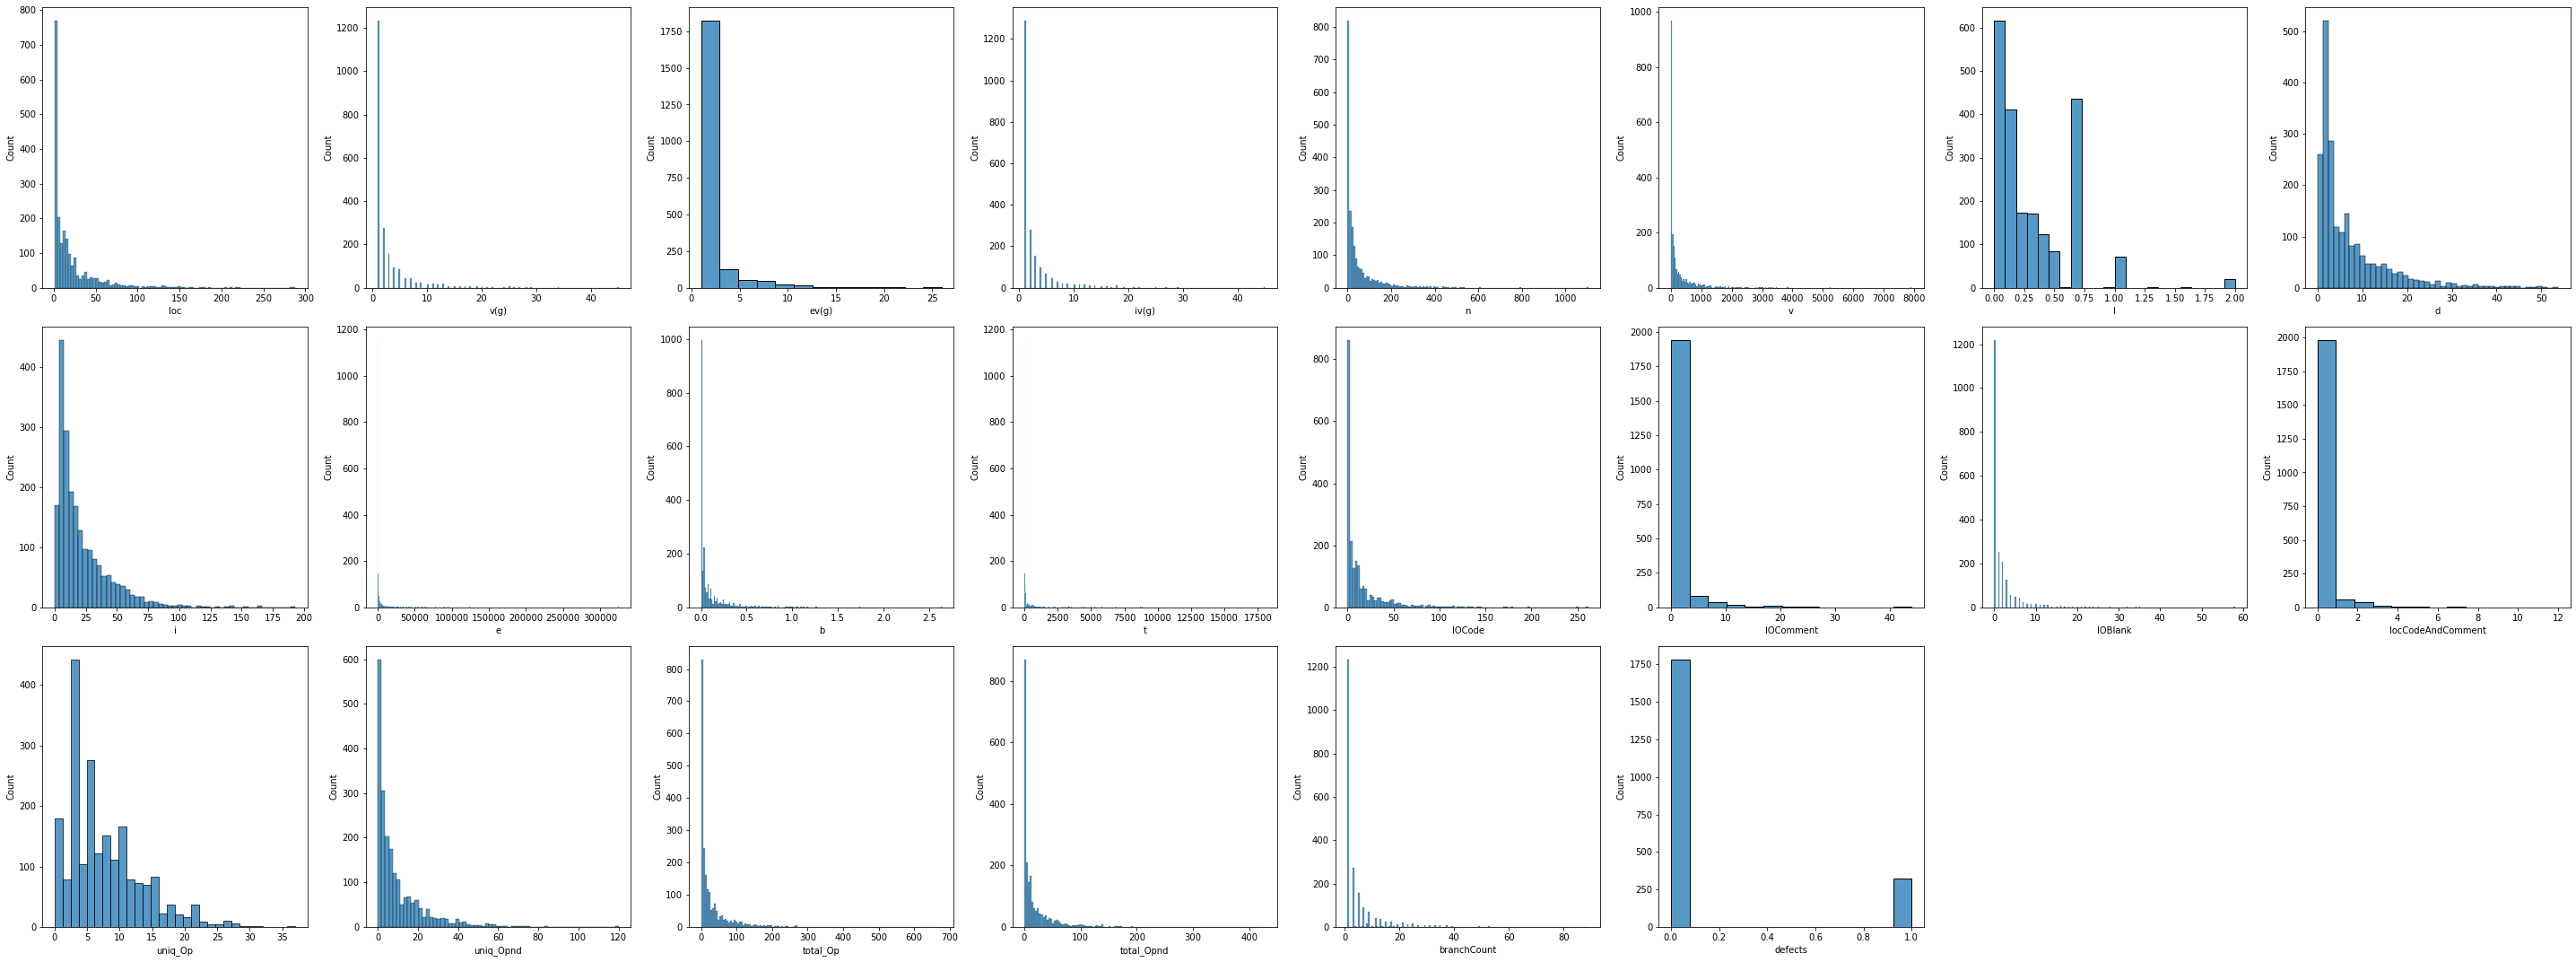

plotting data:   0%|          | 0/22 [00:00<?, ?it/s]

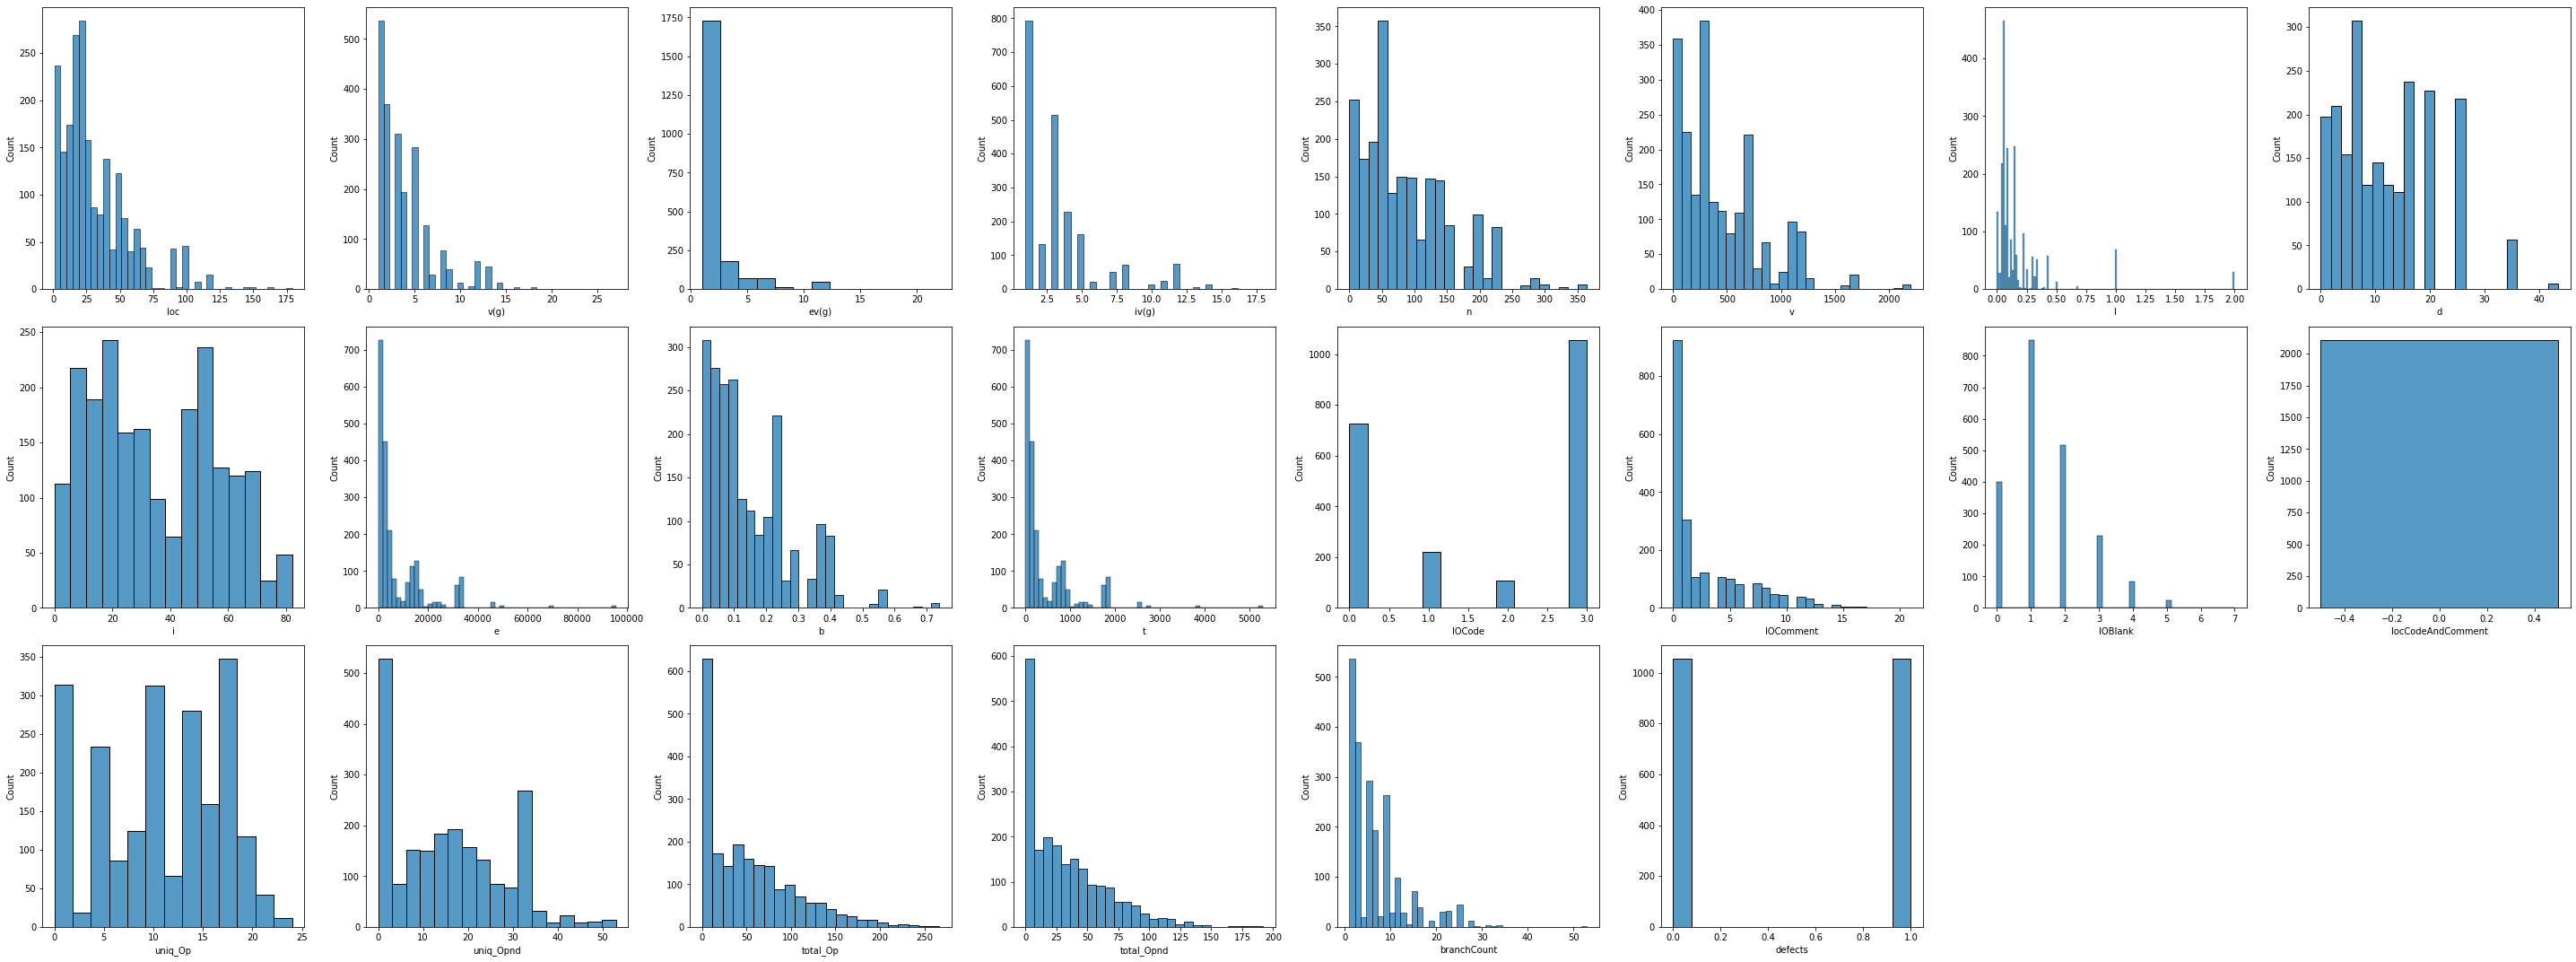

In [6]:
f_name = 'branchCount'

an_nasa.plot_features(inline = 8, color=True)
an_syn.plot_features(inline = 8, color=True)

In [7]:
tester = daat.Verification(ds_nasa_an, ds_aug_kc1)
tester.eval_class_data_set('defects', 0.7)

fitting SVMs:   0%|          | 0/4 [00:00<?, ?it/s]

Data Set Evaluation
--------------------------------------------------------------------------------------------------------------------------
| Modell     ||         OG 70           ||         Syn 70          ||         OG 100          ||         Syn 100         |
| Metric     ||   OG 30    |   Syn 30   ||   OG 30    |   Syn 30   ||   OG 100   |   Syn 100  ||   OG 100   |   Syn 100  |
--------------------------------------------------------------------------------------------------------------------------
| Accuracy   ||      0.856 |      0.550 ||      0.581 |      1.000 ||      0.877 |      0.612 ||      0.549 |      0.999 |
| Precision  ||      0.706 |      1.000 ||      0.265 |      1.000 ||      0.859 |      0.992 ||      0.247 |      0.998 |
| Recall     ||      0.122 |      0.098 ||      0.959 |      1.000 ||      0.243 |      0.226 ||      0.942 |      1.000 |
| F1         ||      0.209 |      0.179 ||      0.415 |      1.000 ||      0.379 |      0.368 ||      0.392 |      0.99

# Test 2: Pima Indians Diabetes Database

In [2]:
# globale Einstellungen
path_ds_diabetes = "./data/diabetes_pima.csv"
ds_diabetes = pd.read_csv(path_ds_diabetes, header=None)

ds_diabetes.columns = ['n_preg', 'plasma_con', 'blood_mm', 'skin_mm', 'insulin', 'bmi', 'dpf', 'age', 'class']
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.age == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.blood_mm == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.skin_mm == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.insulin == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.bmi == 0.0].index)

an_diabetes = daat.Analyser(ds_diabetes, 'class')
an_diabetes.show_dataset_info()
# an_diabetes.plot_features(y_feature='blood_mm', color=True)
# an_diabetes.plot_correlation()

processing features:   0%|          | 0/9 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:           9
Anazhl Einträge:        393
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : class      | Anzahl 2          | ML Art: Klassifikation
größtes Feature   : dpf        | Anzahl 331        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
n_preg               | int64      |        393 |         17 |          0 ||       0.00 |       2.00 |      17.00 
plasma_con           | int64      |        393 |        118 |          0 ||       0.00 |     119.00 |     198.00 
blood_mm             | int64      |        393 |

In [8]:
def advanced_performance_measures(predicted, truth):
    tp = tn = fp = fn = 0

    for i in range(0, len(predicted)):
        if (predicted[i] == 1 and truth[i] == 1): tp += 1
        elif (predicted[i] == 0 and truth[i] == 0): tn += 1
        elif (predicted[i] == 1 and truth[i] == 0): fp += 1
        elif (predicted[i] == 0 and truth[i] == 1): fn += 1

    total = tp + tn + fp + fn
    acc = (tp + tn) / (total)

    pos = tp + fp
    tru = tp + fn

    pre = 0 if pos == 0 else (tp) / (tp + fp)
    rec = 0 if tru == 0 else (tp) / (tp + fn)

    f_s = pre + rec

    f1 = 0 if f_s == 0 else 2 * ((pre * rec) / (f_s))

    return [acc, pre, rec, f1]


# specific test for diabetes dataset.
def run_test_class_ratio(data, target, ratio, cycles, balance = False):
    randomlist = random.sample(range(0, cycles+1), cycles)
    n_samples = len(data)
    metrics = np.zeros((cycles, 9, 4))
    
    for c in trange(cycles, desc='running cycle', leave=False):
    
        # Generator Seed Daten nach ratio bestimmen
        data_x = data.drop(target, axis = 1).to_numpy()
        data_y = data[target].to_numpy()

        x_gen, _, y_gen, _ = train_test_split(data_x, data_y, train_size=ratio, 
                                              random_state=randomlist[c], stratify=data_y)
        y_gen = y_gen.reshape(len(y_gen), 1)
        ds_gen_ratio = pd.DataFrame(np.append(x_gen, y_gen, axis = 1), columns=data.columns)

        # Generator Objekte erstellen
        gen_ratio = daat.Generator(ds_gen_ratio, "class")
        gen_100 = daat.Generator(data, "class")

        # Instruktionen hinzufügen
        gen_ratio.add_instruction(daat_ins("age", daat.Gen_Distribution(rng_min=21)))
        gen_ratio.add_instruction(daat_ins("n_preg", daat.Gen_Distribution(rng_min=0)))
        gen_ratio.add_instruction(daat_ins("blood_mm", daat.Gen_Recombine(15, rng_min=0), ['age']))
        gen_ratio.add_instruction(daat_ins("skin_mm", daat.Gen_Cluster(10, rng_min=0), ['n_preg', 'age']))
        gen_ratio.add_instruction(daat_ins("insulin", daat.Gen_NextMean(5, rng_min=0), ['skin_mm', 'blood_mm']))
        gen_ratio.add_instruction(daat_ins("plasma_con", daat.Gen_NextMean(10, rng_min=0), ['age','insulin']))
        gen_ratio.add_instruction(daat_ins("bmi", daat.Gen_Recombine(5, rng_min=0), ['insulin', 'skin_mm', 'age']))
        gen_ratio.add_instruction(daat_ins("dpf", daat.Gen_NextMean(5, rng_min=0), ['age', 'n_preg']))

        gen_100.add_instruction(daat_ins("age", daat.Gen_Distribution(rng_min=21)))
        gen_100.add_instruction(daat_ins("n_preg", daat.Gen_Distribution(rng_min=0)))
        gen_100.add_instruction(daat_ins("blood_mm", daat.Gen_Recombine(15, rng_min=0), ['age']))
        gen_100.add_instruction(daat_ins("skin_mm", daat.Gen_Cluster(10, rng_min=0), ['n_preg', 'age']))
        gen_100.add_instruction(daat_ins("insulin", daat.Gen_NextMean(5, rng_min=0), ['skin_mm', 'blood_mm']))
        gen_100.add_instruction(daat_ins("plasma_con", daat.Gen_NextMean(10, rng_min=0), ['age','insulin']))
        gen_100.add_instruction(daat_ins("bmi", daat.Gen_Recombine(5, rng_min=0), ['insulin', 'skin_mm', 'age']))
        gen_100.add_instruction(daat_ins("dpf", daat.Gen_NextMean(5, rng_min=0), ['age', 'n_preg']))

        # Daten generieren
        gen_ratio.generate_syn_data(n_samples, balance=balance)
        ds_data_syn_ratio = gen_ratio.get_syn_data()
        gen_100.generate_syn_data(n_samples, balance=balance)
        ds_data_syn_100 = gen_100.get_syn_data()
        

        # original Daten
        org_x = data.drop(target, axis = 1).to_numpy()
        org_y = data[target].to_numpy()
        org_x_train, org_x_test, org_y_train, org_y_test = train_test_split(
            org_x, org_y, train_size = 0.7, random_state = 42, stratify = org_y)
        
        # syn_ratio
        syn_ratio_x = ds_data_syn_ratio.drop(target, axis = 1).to_numpy()
        syn_ratio_y = ds_data_syn_ratio[target].to_numpy()
        syn_ratio_x_train, syn_ratio_x_test, syn_ratio_y_train, syn_ratio_y_test = train_test_split(
            syn_ratio_x, syn_ratio_y, train_size = 0.7, random_state = 42, stratify = syn_ratio_y)
        
        #syn_100
        syn_100_x = ds_data_syn_100.drop(target, axis = 1).to_numpy()
        syn_100_y = ds_data_syn_100[target].to_numpy()
        syn_100_x_train, syn_100_x_test, syn_100_y_train, syn_100_y_test = train_test_split(
            syn_100_x, syn_100_y, train_size = 0.7, random_state = 42, stratify = syn_100_y)
        
        # Erstellen der drei Test-SVMs
        svm_org = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_org.fit(org_x_train, org_y_train)
        
        svm_syn_ratio = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_syn_ratio.fit(syn_ratio_x_train, syn_ratio_y_train)
        
        svm_syn_100 = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_syn_100.fit(syn_100_x_train, syn_100_y_train)
        
        pred_org_o     = svm_org.predict(org_x_test)
        pred_org_srat  = svm_org.predict(syn_ratio_x_test)
        pred_org_s100  = svm_org.predict(syn_100_x_test)
        
        pred_srat_o    = svm_syn_ratio.predict(org_x_test)
        pred_srat_srat = svm_syn_ratio.predict(syn_ratio_x_test)
        pred_srat_s100 = svm_syn_ratio.predict(syn_100_x_test)
        
        pred_s100_o    = svm_syn_100.predict(org_x_test)
        pred_s100_srat = svm_syn_100.predict(syn_ratio_x_test)
        pred_s100_s100 = svm_syn_100.predict(syn_100_x_test)
         
        metrics[c,0] = advanced_performance_measures(pred_org_o, org_y_test)
        metrics[c,1] = advanced_performance_measures(pred_org_srat, syn_ratio_y_test)
        metrics[c,2] = advanced_performance_measures(pred_org_s100, syn_100_y_test)
        
        metrics[c,3] = advanced_performance_measures(pred_srat_o, org_y_test)
        metrics[c,4] = advanced_performance_measures(pred_srat_srat, syn_ratio_y_test)
        metrics[c,5] = advanced_performance_measures(pred_srat_s100, syn_100_y_test)
        
        metrics[c,6] = advanced_performance_measures(pred_s100_o, org_y_test)
        metrics[c,7] = advanced_performance_measures(pred_s100_srat, syn_ratio_y_test)
        metrics[c,8] = advanced_performance_measures(pred_s100_s100, syn_100_y_test)
        
        # TABELLE
        tab_head_1 = '| {:10} || {:30} || {:30} || {:30} |'
        tab_head_2 = '| {:10} || {:8} | {:8} | {:8} || {:8} | {:8} | {:8} || {:8} | {:8} | {:8} |'
        tab_col = ['Metric', 'Accuracy', 'Precision', 'Recall', 'F1']
        tab_head_col = ['Modell', '            OG', '           Syn 10', '          Syn 100']
        header_syn = 'Syn ' + str(100*ratio) 
        tab_head_col_2 = ['Data Set', 'OG 30', header_syn, 'Syn 100', 'OG 30', header_syn, 'Syn 100', 'OG 30', header_syn, 'Syn 100']
        tab_line_1 = '| {:10} || {:8.3f} | {:8.3f} | {:8.3f} || {:8.3f} | {:8.3f} | {:8.3f} || {:8.3f} | {:8.3f} | {:8.3f} |'
        line_len = 9*10 + 14 + 12

        if c == 9 or c == 99 or c == 999:
            
            print('=' * line_len)
            print('Data Set Evaluation for', cycles, 'Cycles, ', ratio, 'Seed Data')
            print('-' * line_len)
            print(tab_head_1.format(*tab_head_col))
            print(tab_head_2.format(*tab_head_col_2))
            print('-' * line_len)
            cyc = c+1
            for j in range(0, len(metrics[0,0])):
                print(tab_line_1.format(tab_col[j+1], 
                                        (np.sum(metrics[:,0,j])/cyc), (np.sum(metrics[:,1,j])/cyc), (np.sum(metrics[:,2,j])/cyc), 
                                        (np.sum(metrics[:,3,j])/cyc), (np.sum(metrics[:,4,j])/cyc), (np.sum(metrics[:,5,j])/cyc), 
                                        (np.sum(metrics[:,6,j])/cyc), (np.sum(metrics[:,7,j])/cyc), (np.sum(metrics[:,8,j])/cyc)
                     ))
            print('=' * line_len)

In [9]:
run_test_class_ratio(ds_diabetes, 'class', 0.1, 1000, balance=True)

running cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 1000 Cycles,  0.1 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.856 |    0.724 ||    0.713 |    0.998 |    0.928 ||    0.650 |    0.926 |    0.981 |
| Precision  ||    0.686 |    0.981 |    0.994 ||    0.565 |    0.997 |    0.972 ||    0.484 |    0.879 |    0.977 |
| Recall     ||    0.615 |    0.736 |    0.591 ||    0.638 |    1.000 |    0.920 ||    0.849 |    0.998 |    0.995 |
| F1         ||    0.649 |    0.833 |    0.740 ||    0.586 |    0.998 |    0.943 ||    0.616 |    0.934 |    0.986 |


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 1000 Cycles,  0.1 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.857 |    0.724 ||    0.714 |    0.998 |    0.871 ||    0.641 |    0.885 |    0.981 |
| Precision  ||    0.686 |    0.978 |    0.995 ||    0.567 |    0.997 |    0.963 ||    0.477 |    0.831 |    0.977 |
| Recall     ||    0.615 |    0.740 |    0.591 ||    0.669 |    1.000 |    0.844 ||    0.866 |    0.994 |    0.994 |
| F1         ||    0.649 |    0.830 |    0.740 ||    0.601 |    0.998 |    0.887 ||    0.615 |    0.903 |    0.986 |


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 1000 Cycles,  0.1 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.843 |    0.724 ||    0.709 |    0.997 |    0.886 ||    0.638 |    0.883 |    0.978 |
| Precision  ||    0.686 |    0.978 |    0.995 ||    0.555 |    0.996 |    0.952 ||    0.475 |    0.829 |    0.975 |
| Recall     ||    0.615 |    0.711 |    0.590 ||    0.669 |    0.999 |    0.875 ||    0.866 |    0.991 |    0.993 |
| F1         ||    0.649 |    0.808 |    0.739 ||    0.594 |    0.998 |    0.904 ||    0.613 |    0.900 |    0.984 |
